In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/restaurant-sales-dirty-data-for-cleaning-training/restaurant_sales_data.csv


# Data preprocessing

In [2]:
import pandas as pd

df = pd.read_csv("/kaggle/input/restaurant-sales-dirty-data-for-cleaning-training/restaurant_sales_data.csv")


In [3]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [4]:
df.sample(6)

,Order ID,Customer ID,Category,Item,Price,Quantity,Order Total,Order Date,Payment Method
3026,ORD_808129,CUST_021,Desserts,Cheesecake,7.0,5.0,35.0,2023-03-07,Credit Card
11708,ORD_967197,CUST_089,Desserts,Fruit Salad,4.0,1.0,4.0,2022-09-21,Cash
5039,ORD_554438,CUST_021,Side Dishes,Grilled Vegetables,5.0,5.0,25.0,2023-05-26,Credit Card
3603,ORD_116533,CUST_091,Starters,Cheese Fries,5.0,2.0,10.0,2023-01-09,Digital Wallet
16468,ORD_598836,CUST_046,Side Dishes,Onion Rings,5.0,2.0,10.0,2023-08-18,Credit Card
10566,ORD_596951,CUST_058,Drinks,Orange Juice,3.0,4.0,12.0,2023-09-23,Credit Card


In [5]:
# Inspect basic structure
print("Basic info:")
print(df.info())
print("\nPreview:")
print(df.head())

Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17534 entries, 0 to 17533
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order ID        17534 non-null  object 
 1   Customer ID     17534 non-null  object 
 2   Category        17534 non-null  object 
 3   Item            15776 non-null  object 
 4   Price           16658 non-null  float64
 5   Quantity        17104 non-null  float64
 6   Order Total     17104 non-null  float64
 7   Order Date      17534 non-null  object 
 8   Payment Method  16452 non-null  object 
dtypes: float64(3), object(6)
memory usage: 1.2+ MB
None

Preview:
     Order ID Customer ID     Category             Item  Price  Quantity  \
0  ORD_705844    CUST_092  Side Dishes       Side Salad    3.0       1.0   
1  ORD_338528    CUST_021  Side Dishes  Mashed Potatoes    4.0       3.0   
2  ORD_443849    CUST_029  Main Dishes  Grilled Chicken   15.0       4.0   
3  ORD_630508 

* Rows: 17,534

* Columns: 9

* Has missing values: Item, Price, Quantity, Order Total, Payment Method

* Data types: 6 object columns, 3 float columns

* Order Date is stored as object (not datetime)

* Preview shows: typical order data (IDs, category, item, price, quantity, totals, date, payment method)

  

Order ID             0
Customer ID          0
Category             0
Item              1758
Price              876
Quantity           430
Order Total        430
Order Date           0
Payment Method    1082
dtype: int64

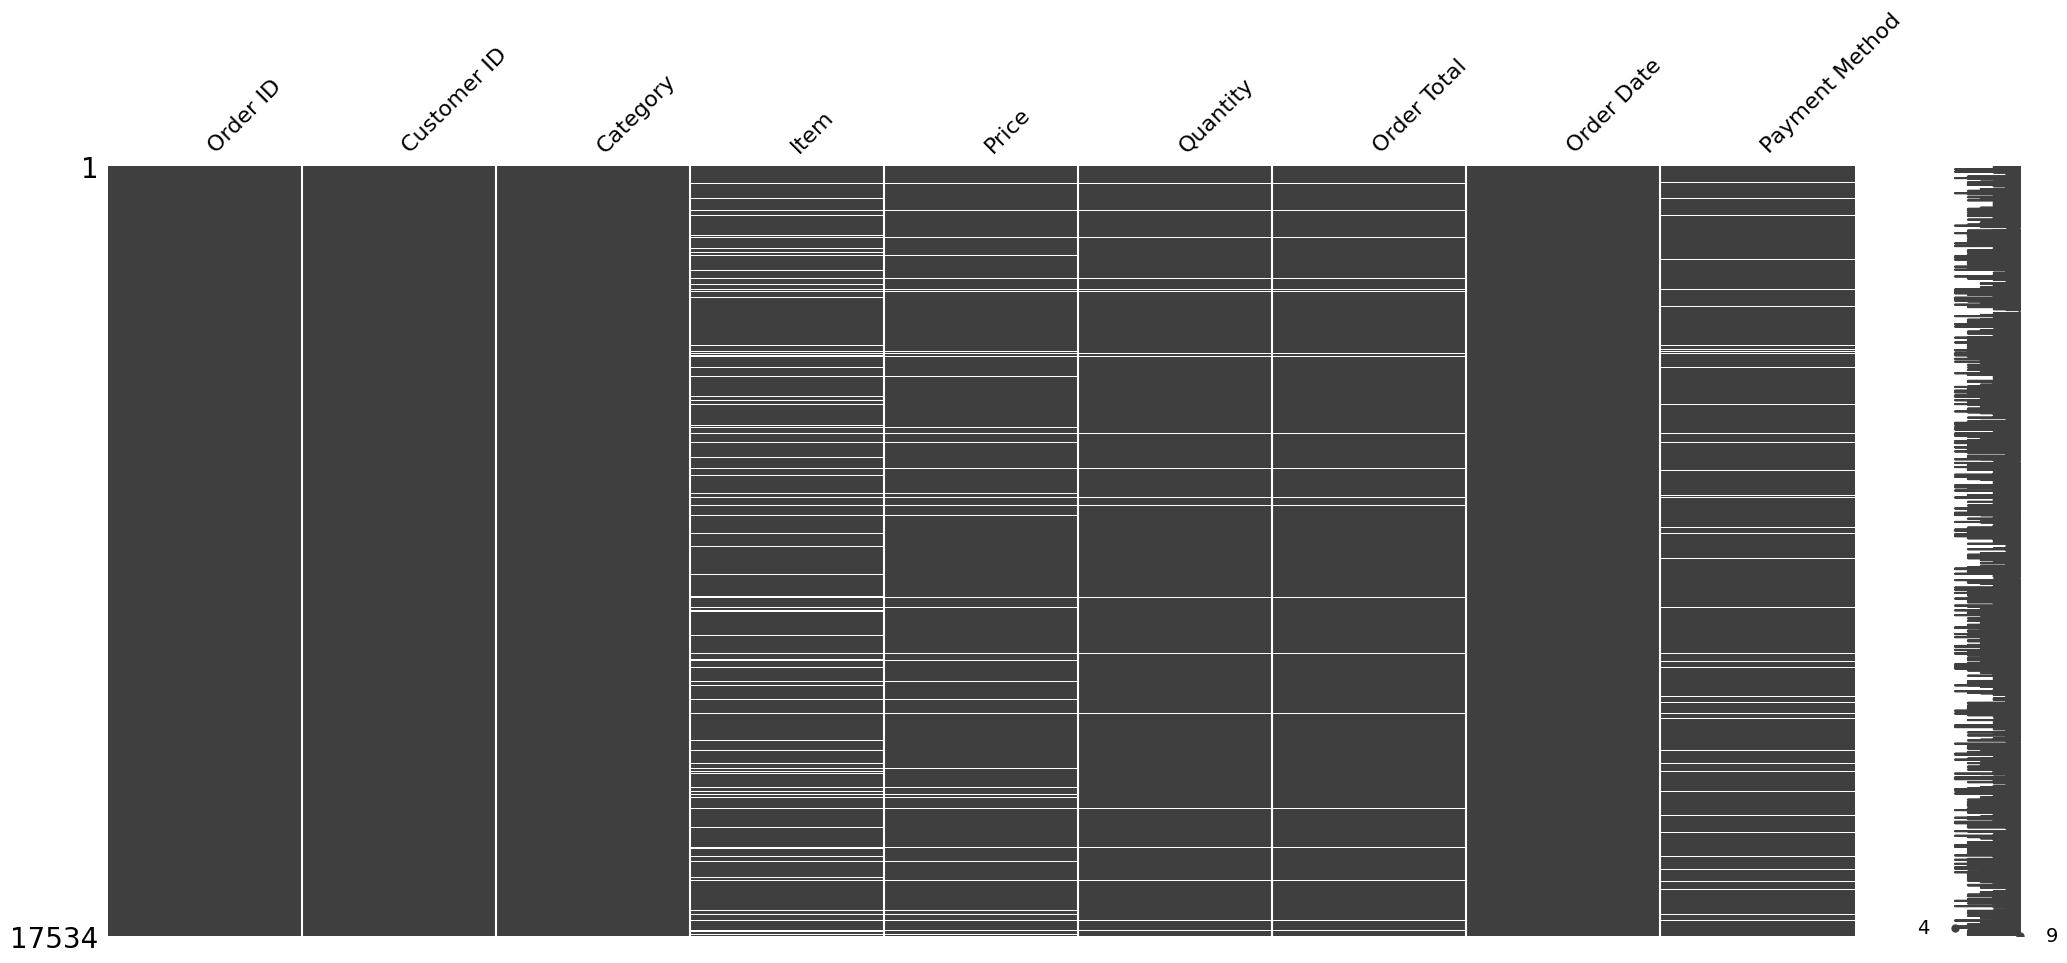

In [6]:
import missingno as msno
msno.matrix(df)
df.isnull().sum()

In [7]:
df = df.drop_duplicates()

In [8]:
df.isnull().sum()

Order ID             0
Customer ID          0
Category             0
Item              1758
Price              876
Quantity           430
Order Total        430
Order Date           0
Payment Method    1082
dtype: int64

* so no duplicate ... just missing value

In [9]:
#  Replace placeholders
placeholders = ["unknown", "Unknown", "UNK", "N/A", "na", "Na", "NA", "", " "]
df = df.replace(placeholders, pd.NA)

In [10]:
# Convert numeric columns 

num_cols = ["Quantity", "Price", "Order Total"]

for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")


* It converts the Quantity, Price, and Order Total columns to numeric values, turning anything invalid into NaN

In [11]:
# Recalculate Order Total where needed
if "Order Total" in df.columns and "Quantity" in df.columns and "Price" in df.columns:
    missing_total = df["Order Total"].isna()  # find missing totals
    df.loc[missing_total, "Order Total"] = df.loc[missing_total, "Quantity"] * df.loc[missing_total, "Price"]


* The code finds rows where Order Total is missing and fills them by multiplying Quantity × Price

In [12]:
# 6. Convert date columns
for col in df.columns:
    if "Order date" in col:
        df[col] = pd.to_datetime(df[col], errors="coerce")

* The code looks for any column with "date" in its name and converts it to datetime format. Invalid values become NaN.

In [13]:
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True, errors='coerce')

# Format the date as dd-mm-yyyy
df['Order Date'] = df['Order Date'].dt.strftime('%d-%m-%Y')


print(df[['Order Date', 'Payment Method']].head())

   Order Date  Payment Method
0  21-12-2023     Credit Card
1  19-05-2023  Digital Wallet
2  27-09-2023     Credit Card
3  09-08-2022     Credit Card
4  15-05-2022            Cash


/tmp/ipykernel_156/1269738084.py:1: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True, errors='coerce')


In [14]:
df.sample(5)

,Order ID,Customer ID,Category,Item,Price,Quantity,Order Total,Order Date,Payment Method
10585,ORD_347622,CUST_067,Starters,Beef Chili,7.0,3.0,21.0,24-04-2022,Cash
14152,ORD_692664,CUST_050,Desserts,NaN,NaN,4.0,24.0,12-12-2023,Cash
10485,ORD_828188,CUST_060,Drinks,Water,1.0,4.0,4.0,30-10-2023,Credit Card
15933,ORD_796961,CUST_010,Main Dishes,Vegetarian Platter,14.0,3.0,42.0,19-03-2023,Digital Wallet
2395,ORD_208497,CUST_014,Side Dishes,Grilled Vegetables,5.0,5.0,25.0,27-02-2022,Credit Card


In [15]:
df.isnull().sum()

Order ID             0
Customer ID          0
Category             0
Item              1758
Price              876
Quantity           430
Order Total        430
Order Date           0
Payment Method    1082
dtype: int64

In [16]:
# Fill missing numeric columns with 0
num_cols = ["Price", "Quantity", "Order Total"]
for col in num_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# Fill missing categorical columns with "Unknown"
cat_cols = ["Item", "Payment Method"]
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown")


print(df.head())

     Order ID Customer ID     Category             Item  Price  Quantity  \
0  ORD_705844    CUST_092  Side Dishes       Side Salad    3.0       1.0   
1  ORD_338528    CUST_021  Side Dishes  Mashed Potatoes    4.0       3.0   
2  ORD_443849    CUST_029  Main Dishes  Grilled Chicken   15.0       4.0   
3  ORD_630508    CUST_075       Drinks          Unknown    0.0       2.0   
4  ORD_648269    CUST_031  Main Dishes    Pasta Alfredo   12.0       4.0   

   Order Total  Order Date  Payment Method  
0          3.0  21-12-2023     Credit Card  
1         12.0  19-05-2023  Digital Wallet  
2         60.0  27-09-2023     Credit Card  
3          5.0  09-08-2022     Credit Card  
4         48.0  15-05-2022            Cash  


<Axes: >

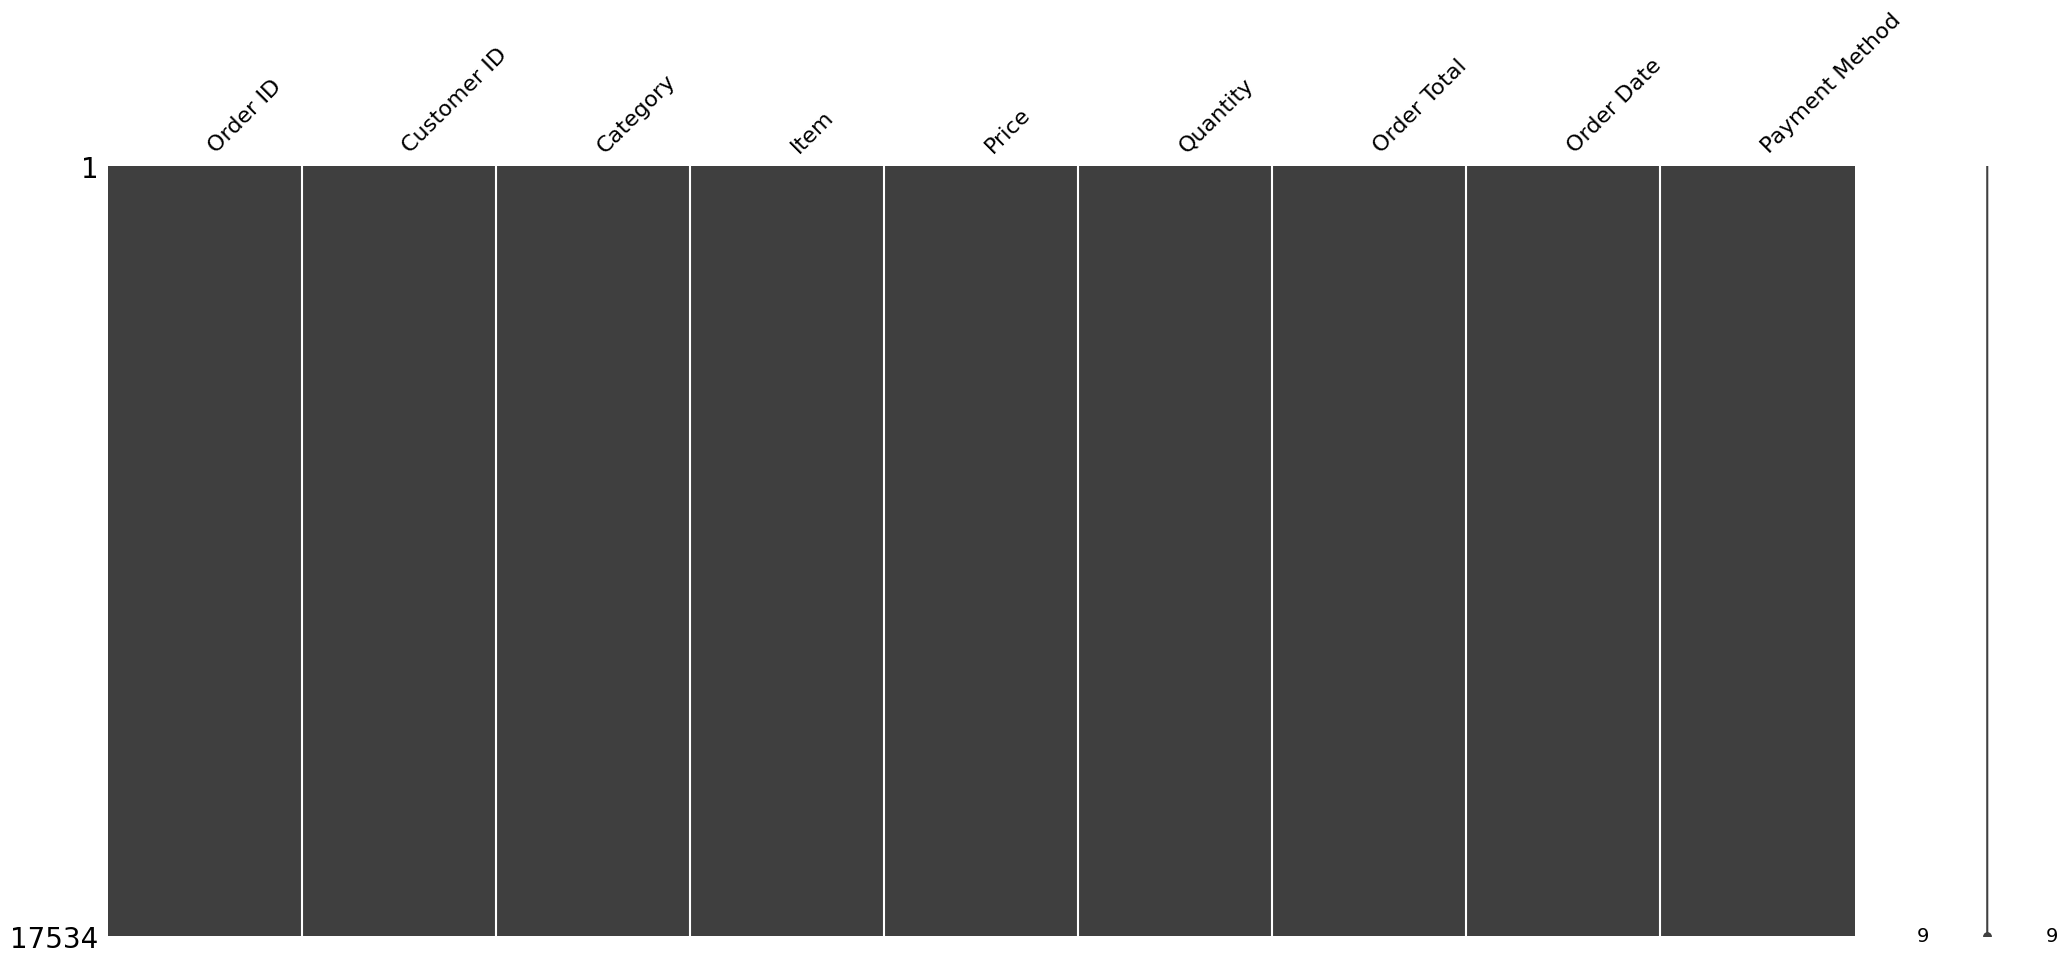

In [17]:
msno.matrix(df)